# Российский рынок

Применение метода Марковица для оптимизации портфеля, состоящего из акций российского фондового рынка, входящих в индекс московской биржи

https://www.moex.com/ru/index/IMOEX/constituents/

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from tqdm import tqdm_notebook

%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

Создаем список акций, входящих в индекс московской биржи

In [2]:
stocks = ["AFKS",
          "AFLT",
          "ALRS",
          "CBOM",
          "CHMF",
          "DSKY",
          "FEES",
          "GAZP",
          "GMKN",
          "HYDR",
          "IRAO",
          "LKOH",
          "MAGN",
          "MGNT",
          "MOEX",
          "MTLR",
          "MTSS",
          "MVID",
          "NLMK",
          "NVTK",
          "PHOR",
          "PIKK",
          "PLZL",
          "POLY",
          "RNFT",
          "ROSN",
          "RTKM",
          "RUAL",
          "SBER",
          "SBERP",
          "SNGS",
          "SNGSP",
          "TATN",
          "TATNP",
          "TRMK",
          "TRNFP",
          "UPRO",
          "UWGN",
          "VTBR",
          "YNDX"]

Загружаем индекс Московской Биржи (IMOEX)

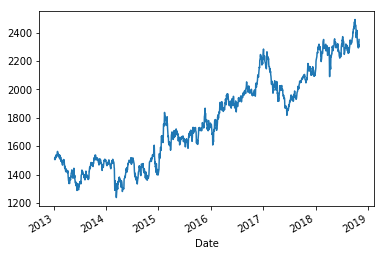

In [3]:
imoex = pd.read_csv('./csv/'+'IMOEX.csv', parse_dates=['Date'], index_col=0)['Close']['2013-01-01':'2018-10-31']
imoex.plot();

Загружаем цены закрытия акций

In [ ]:
price = pd.DataFrame()
for symbol in stocks:
    price[symbol] = pd.read_csv('./csv/'+symbol+'.csv', parse_dates=['Date'], index_col=0)['Close']['2013-01-01':'2018-10-31']

In [ ]:
price.head()

In [ ]:
# How NaN rows
price.isnull().sum()

Удаляем из таблицы акции у которых пропусков (NaN) больше 50

In [ ]:
isnull = price.isnull().sum()
for ticker in stocks:     #если слишком много значений null исключаем акцию из анализа
    try:
        if isnull[ticker] > 50:
            price.drop(ticker, axis=1, inplace=True)
    except:
        pass

Итоговый список анализируемых акций

In [10]:
# How NaN rows
price.isnull().sum()

AFKS      0
AFLT      0
ALRS      0
CHMF      0
FEES      0
GAZP      0
GMKN      0
HYDR      0
IRAO     18
LKOH      0
MAGN      0
MGNT      0
MOEX     28
MTLR      0
MTSS      9
MVID      0
NLMK      0
NVTK      0
PHOR      0
PIKK      0
PLZL      0
ROSN      0
RTKM      9
SBER      0
SBERP     0
SNGS      0
SNGSP     0
TATN      0
TATNP     0
TRMK      0
TRNFP     0
UPRO      1
VTBR      0
dtype: int64

In [11]:
# Delete NaN rows
#price.dropna(inplace=True)

## Постановки задачи оптимизации инвестиционного портфеля

решение задачи оптимизации и поиска оптимальной границы портфелей

In [12]:
risk_free_rate = 0.0 # Безрисковая процентная ставка
num_periods_annually = 252 # Количество операционных дней в году

In [13]:
returns = price.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

Считаем риск и доходность каждой акции в годовом исчислении

In [14]:
a_rsk = np.std(returns) * np.sqrt(num_periods_annually)
a_ret = mean_returns*num_periods_annually

In [15]:
# Функция вычисляющая риск и доходность для конкретного портфеля
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

---

Функции для оптимизации по максимальному коэффициенту Шарпа

In [16]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [17]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

---

Функции для оптимизации по минимальному риску

In [18]:
def portfolio_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

In [19]:
def min_risk(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

---

Функции для оптимизации по максимальной доходности

In [20]:
def neg_portfolio_return(weights, mean_returns, cov_matrix):
    return -1*portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [21]:
def max_return(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

---

Функции для поиска оптимальной границы

In [22]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [23]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

---

Оптимизируем. Ищем портфель с максимальным коэффициентом шарпа (sharpe_max), минимальным риском (risk_min), максимальной доходностью (return_max)

In [24]:
sharpe_max = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
risk_min = min_risk(mean_returns, cov_matrix)
return_max = max_return(mean_returns, cov_matrix)

Пример возвращаемого объекта результата оптимизиции.

х - найденый портфель

In [25]:
return_max

     fun: -0.3283838128339424
     jac: array([ 0.02368218, -0.19011711, -0.25331793, -0.21394391, -0.03407828,
       -0.03864003, -0.15371063, -0.00303837, -0.14808797, -0.18385013,
       -0.31548769,  0.00457478, -0.12726737, -0.08680056, -0.04776141,
       -0.1350291 , -0.20156235, -0.23153723, -0.15236923, -0.32838381,
       -0.32215434, -0.12345491,  0.0669049 , -0.16632349, -0.19517444,
       -0.02321104, -0.14537151, -0.27025895, -0.30526783,  0.01563392,
       -0.20798329, -0.04157136,  0.03031233])
 message: 'Optimization terminated successfully.'
    nfev: 525
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([2.63826865e-16, 0.00000000e+00, 0.00000000e+00, 6.44170262e-16,
       0.00000000e+00, 4.10722308e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.20784621e-16,
       1.28099756e-16, 0.00000000e+00, 5.43549664e-17, 2.12265582e-16,
       0.00000000e+00, 1.56126870e-16, 1.45491375e-16, 1.00000000e+00,

Вычисляем риски и доходности найденых портфелей

In [26]:
sharpe_std, sharpe_ret = portfolio_performance(sharpe_max['x'], mean_returns, cov_matrix)
min_std, min_ret = portfolio_performance(risk_min['x'], mean_returns, cov_matrix)
max_std, max_ret = portfolio_performance(return_max['x'], mean_returns, cov_matrix)

Находим (оптимизируем) эффективную границу портфелей

In [ ]:
target = np.linspace(min_ret, max_ret, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio

Return: 0.301
Risk: 0.157
Sharpe Ratio: 1.915
--------------------------------------------------------------------------------
Minimum Risk Portfolio

Return: 0.18
Risk: 0.135
Sharpe Ratio: 1.329
--------------------------------------------------------------------------------
Maximum Return Portfolio

Return: 0.328
Risk: 0.269
Sharpe Ratio: 1.219


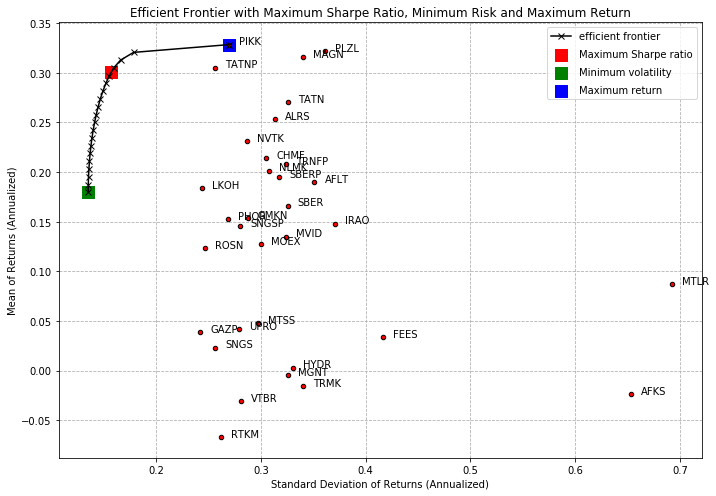

In [39]:
print("-"*80)
print("Портфель с максимальным коэффициентом Шарпа\n")
print("Доходность:", round(sharpe_ret,3))
print("Риск:", round(sharpe_std,3))
print("Коэффициент Шарпа:", round((sharpe_ret - risk_free_rate)/sharpe_std, 3))
print("-"*80)
print("Портфель с минимальным риском\n")
print("Доходность:", round(min_ret,3))
print("Риск:", round(min_std,3))
print("Коэффициент Шарпа:", round((min_ret - risk_free_rate)/min_std, 3))
print("-"*80)
print("Портфель с максимальным показателем доходности\n")
print("Доходность:", round(max_ret,3))
print("Риск:", round(max_std,3))
print("Коэффициент Шарпа::", round((max_ret - risk_free_rate)/max_std, 3))

plt.figure(figsize=(10, 7))

#plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)

plt.scatter(sharpe_std, sharpe_ret, marker='s', color='r', s=150, label='Макс. коэф-т Шарпа)
plt.scatter(min_std, min_ret, marker='s', color='g', s=150, label='Мин. риск')
plt.scatter(max_std, max_ret, marker='s', color='b', s=150, label='Макс. доходность')

plt.scatter(a_rsk, a_ret, marker='o', s=20, c='red', edgecolors='black')
for i, txt in enumerate(price.columns):
    plt.annotate(txt, (a_rsk[i], a_ret[i]), xytext=(10,0), textcoords='offset points')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')

plt.grid(True, linestyle='--')
plt.title('Граница эффективности с Максимальным коэффициентом Шарпа, Минимальным риском и Максимальной доходностью')
plt.xlabel('Риск (годовой)')
plt.ylabel('Доходность (годовая)')
plt.legend(labelspacing=0.8)

#plt.xlim(0.1, 0.5)
#plt.ylim(-0.05, 0.25)

plt.tight_layout();

## Вычисление портфеля с заданным показателем риска и заданным уровнем доходности

Указываем целевой риск и доходность

In [40]:
TargetReturn = 0.20
TargetRisk = 0.15

Функции для поиска портфеля для целевого риска и доходности

In [41]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

In [42]:
def portfolio_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

In [43]:
def targeted_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [44]:
def neg_portfolio_return(weights, mean_returns, cov_matrix):
    return -1*portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [45]:
def targeted_risk(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_risk(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_risk(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Вычисляем портфель для заданоого целевого риска и доходности

In [46]:
t_return = targeted_return(mean_returns, cov_matrix, TargetReturn)
t_risk = targeted_risk(mean_returns, cov_matrix, TargetRisk)

In [47]:
sdp_return, rp_return = portfolio_performance(t_return['x'], mean_returns, cov_matrix)
sdp_risk, rp_risk = portfolio_performance(t_risk['x'], mean_returns, cov_matrix)

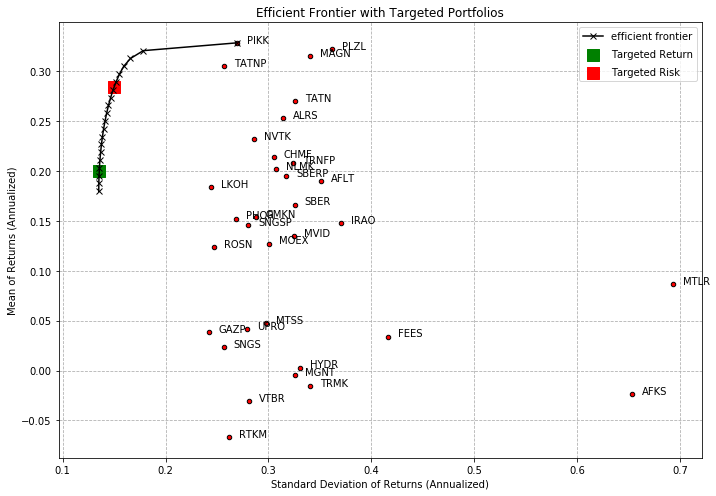

In [48]:
plt.figure(figsize=(10, 7))

plt.scatter(sdp_return, rp_return, marker='s', color='g', s=150, label='Заданная Доходность')
plt.scatter(sdp_risk, rp_risk, marker='s', color='r', s=150, label='Заданный Риск')

plt.scatter(a_rsk, a_ret, marker='o', s=20, c='red', edgecolors='black')
for i, txt in enumerate(price.columns):
    plt.annotate(txt, (a_rsk[i], a_ret[i]), xytext=(10,0), textcoords='offset points')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')

plt.grid(True, linestyle='--')
plt.title('Граница эффективности с заданным портфелем')
plt.xlabel('Риск (годовой)')
plt.ylabel('Доходность (годовая)')
plt.legend(labelspacing=0.8)

#plt.xlim(0.1, 0.5)
#plt.ylim(-0.05, 0.5)

plt.tight_layout();

Посмотрим распределение акций в портфеле

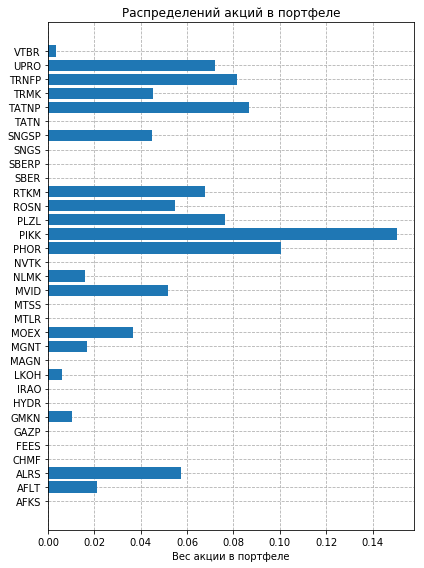

In [49]:
ind = np.arange(price.columns.size)

plt.figure(figsize=(6,8))

#plt.barh(ind, sharpe_max['x'], align='center')
plt.barh(ind, risk_min['x'], align='center')
#plt.barh(ind, return_max['x'], align='center')
#plt.barh(ind, t_return['x'], align='center')
#plt.barh(ind, t_risk['x'], align='center')

plt.yticks(ind, price.columns)
plt.xlabel('Вес акции в портфеле')
plt.title('Распределений акций в портфеле')
#plt.legend(('Max Sharpe Ratio', 'Minimum Volatility'))
plt.grid(b=True, linestyle='--')

plt.tight_layout();

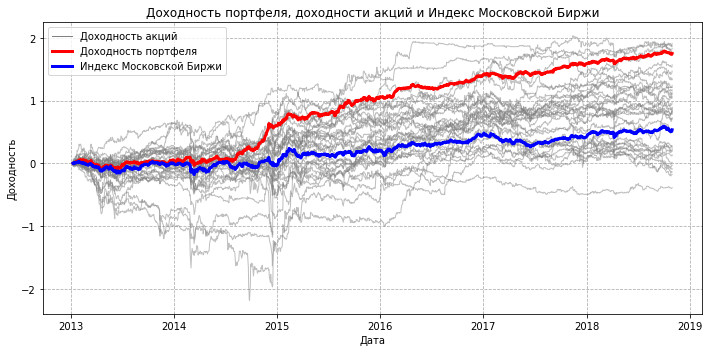

In [51]:
# Построение графика всех акций и доходности конкретного портфеля
portfolio_alloc = sharpe_max['x']
#portfolio_alloc = risk_min['x']
#portfolio_alloc = return_max['x']
#portfolio_alloc = t_return['x']
#portfolio_alloc = t_risk['x']

index = price.index
p_returns = pd.DataFrame(columns=['returns'])
for day in range(1, price.index.size):
    # Calculating portfolio return
    date0 = index[day]
    date1 = index[day-1]
    a_return = (price.loc[date0] - price.loc[date1])/price.loc[date1]
    p_returns.loc[index[day]] = np.sum(a_return*portfolio_alloc)

plt.figure(figsize=(10,5))

gray_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Доходность акций')
plt.plot(price.pct_change().cumsum(),'gray', linewidth=1, alpha=0.5)

red_line = mlines.Line2D([], [], color='red', linewidth=3, label='Доходность портфеля')
plt.plot(p_returns.cumsum(), 'red', linewidth=3)

blue_line = mlines.Line2D([], [], color='blue', linewidth=3, label='Индекс Московской Биржи')
plt.plot(imoex.pct_change().cumsum(), 'blue', linewidth=3)

plt.grid(True, linestyle='--')
plt.title('Доходность портфеля, доходности акций и Индекс Московской Биржи')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.legend(handles=[gray_line, red_line, blue_line])
plt.tight_layout();

Т.о. в результате оптимизации удалось собрать портфель с максимальным коэффициентом Шарпа, который по доходности больше доходности индекса Московской Биржи за последние 6 лет

In [52]:
p = (-sharpe_max['fun'] * 100)/6
print('Cредняя годовая доходность портфеля:', str(round(p, 2))+'%')

im = (imoex.pct_change().cumsum()[-1] * 100)/6
print('Cредняя годовая доходность индекса Московской Биржи:', str(round(im, 2))+'%')

print('Cредняя годовая доходность портфеля / индекс Московской Биржи:', round(p/im, 2))

Cредняя годовая доходность портфеля: 31.91%
Cредняя годовая доходность индекса Московской Биржи: 8.93%
Cредняя годовая доходность портфеля / индекс Московской Биржи: 3.57


# Построение Динамичной Границы Эффективности

https://quantdare.com/dynamic-markowitz-efficient-frontier/

Модель Марковица – один из самых известных методов портфельной теории, обеспечивает вычисление эффективных портфелей посредством математического программирования. Набор портфелей составляет эффективную границу. Стратегия основана на квадратичной оптимизации, поэтому минимизирует оценочный риск и отрицательную доходность.  Эффективная граница вычислялась с использованием фиксированного временного окна, основанного на исторических данных. Реальный рынок не использует большие окна данных для расчета портфеля средней дисперсии. Поэтому интересно проанализировать эволюцию границы на основе временной шкалы. Здесь включены результаты динамической границы в статическом представлении с использованием Six Month Rolling Method


## Six Month Rolling Method

Данный метод состоит из последовательного просмотра серии данных, в частности эффективных границ. В качестве ширина окна выбран полугодовой интервал (126 дней).

In [437]:
# Окно (дни)
rolling = 126

#смещение во времени для каждой границы
offset = 5 

risk_free_rate = 0.0 # Безрисковая процентная ставка
num_periods_annually = rolling # коэффициент для преобразования периодичности в годовой период

Формируем словарь в котором будем хранить по годам эффективные границы в виде списка

In [438]:
dm_risk = {}
dm_return = {}
for year in index.year.unique():
    dm_risk[year] = []
    dm_return[year] = []

In [439]:
dm_risk

{2013: [], 2014: [], 2015: [], 2016: [], 2017: [], 2018: []}

In [440]:
dm_return

{2013: [], 2014: [], 2015: [], 2016: [], 2017: [], 2018: []}

In [441]:
# списки для отрисовки 3D графика
sr_risk = []
sr_return = []

index = price.index

for day in tqdm_notebook(range(rolling, price.index.size, offset)):
    # Вырезаем часть таблицы размером rolling
    date0 = index[day]
    date1 = index[day-rolling+1]
    p = price.loc[date1:date0]
    
    # далее тот же код по оптимизации, что и выше. Но только теперь мы передоаем в него части таблицы цен
    returns = p.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    risk_min = min_risk(mean_returns, cov_matrix)
    return_max = max_return(mean_returns, cov_matrix)
    
    min_std, min_ret = portfolio_performance(risk_min['x'], mean_returns, cov_matrix)
    max_std, max_ret = portfolio_performance(return_max['x'], mean_returns, cov_matrix)
    
    target = np.linspace(min_ret, max_ret, 20)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    
    # Вытаскиваем из результатов оптимизации эффективную границу и сохраняем ее в словарь
    dm_risk[index[day].year].append([p['fun'] for p in efficient_portfolios])
    dm_return[index[day].year].append(target)
    
    # списки для отрисовки 3D графика
    sr_risk.append([p['fun'] for p in efficient_portfolios])
    sr_return.append(target)

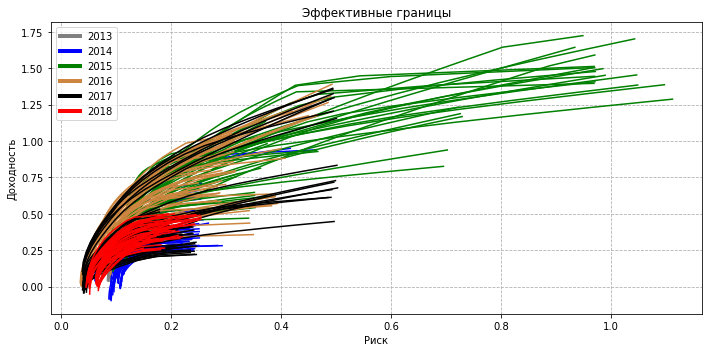

In [442]:
c = ['gray', 'blue', 'green', 'peru', 'black', 'red']
l = []
t = 0
plt.figure(figsize=(10,5))
for year in index.year.unique():
    l.append(mlines.Line2D([], [], color=c[t], linewidth=4, label=index.year.unique()[t]))
    for i in range(len(dm_risk[year])):
        plt.plot(dm_risk[year][i], dm_return[year][i], c=c[t])
    t = t + 1

plt.grid(True, linestyle='--')
plt.title('Эффективные границы')
plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.legend(handles=l)
plt.tight_layout();

Когда мы рассматриваем фиксированный период, не накапливая наблюдения, риск и доходность портфелей движутся иначе. В 2015 году риск увеличивается по сравнению с другими годами.  В частности, это более 100%, тогда как в 2017 и 2018 годах он падает ниже 30%. Таким образом, динамическая эффективная граница может является наглядным примером эффекта добавления новых наблюдений с фиксированной начальной датой или в скользящий период. 

# Поиск стабильного региона

https://www.mathworks.com/company/newsletters/articles/developing-portfolio-optimization-models.html

Эффективные границы подвержены изменениям: некогда эффективный портфель может перестать быть доминирующим. Данный вопрос быть решен изучением временной эволюции эффективных границ и определением таких последовательностей портфелей, которые остаются относительно стабильными от одного рубежа к другому. Мы можем использовать Python для визуализации этой стабильной области.

In [477]:
from plotly.offline import init_notebook_mode
#для вывода plotly-графиков в ноутбуке
init_notebook_mode(connected=True)

In [478]:
y = np.array(sr_risk)
z = np.array(sr_return)

In [479]:
a = np.linspace(2013, 2019, y.shape[0])
x = np.repeat(a[None], y.shape[1], axis=0).T

In [480]:
data = [
    go.Surface(
        x=x,
        y=y,
        z=z
    )
]

In [481]:
layout = go.Layout(
    title='Эффективные границы',
    width=800,
    height=700,
    scene=dict(
        xaxis=dict(
            title='Дата',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Риск',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(title='Доходность',
                   gridcolor='rgb(255, 255, 255)',
                   zerolinecolor='rgb(255, 255, 255)',
                   showbackground=True,
                   backgroundcolor='rgb(230, 230,230)'
                  )
    )
)

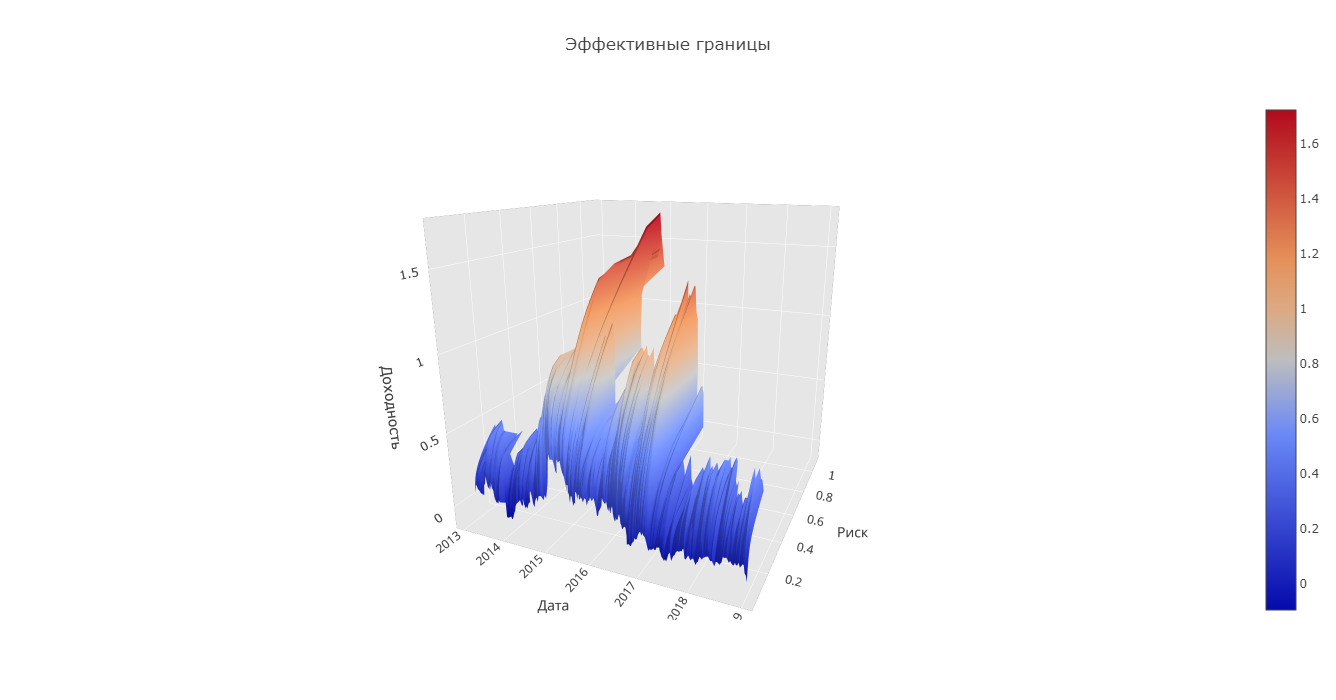

In [482]:
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

Приведенный рисунок отражает эффективные границы на графике как функцию времени. Python рассчитал эффективные границы с 40 портфелями на каждой границы с интервалом в один месяц и построил график результатов. Данный рисунок позволяет выделить стабильный регион (темно-голубая область) – последовательность портфелей с небольшим отклонением доходности или риска и с неизменно положительной ожидаемой доходностью по отношению к рынку.
